# Summary

**PURPOSE**

TinyAE (using upscaled temperature states) with a sublinear FCN that enforces the koopman constraint.

The goal of this notebook is to see if this methodology works well enough.

**IF SUCCESSFULL**

Now try it with autoregressive prediction to enhance long term predictions.

TODO:

1. If this model can predict well. Ask for run on cloud to train the upsampled model.

from diffusers import AutoencoderKL# Imports

In [1]:
import os
import copy
import time
import numpy as np
import scipy as sp
import scipy.sparse as sprse
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
import torch
from tqdm.notebook import tqdm_notebook
from torchvision.transforms import v2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.utils.checkpoint as checkpoint
import torch.optim as optim
import torch
from torch import nn
from diffusers import AutoencoderKL
from diffusers import AutoencoderTiny
import accelerate
import matplotlib.animation as animation
from transformers import ViTModel, ViTConfig, ViTImageProcessor
import random
import torch.nn.functional as F

2024-11-20 11:38:24.082041: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 11:38:24.102937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 11:38:24.129290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 11:38:24.140538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 11:38:24.161814: I tensorflow/core/platform/cpu_feature_guar

# Dataset Configuration

Configuration class for for the dataset side of the program.

In [2]:
class datasetConfig:
    fixed_seq_len = 216
    path = '/data/users/jupyter-dam724/datadump(colliding)'
    solver = 'ros2'
    seed = 32
    
    device_pref = 'cuda'
    device = None
    
    batch_size = 64 # 22
    num_workers = 32
    ahead = 1
    tail = 1
    loader_speed = False
    
    upsample = True
    
    vit_preproccessor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

*Seed torch for reproducibility.*

In [3]:
torch.manual_seed(datasetConfig.seed)
torch.set_printoptions(precision=10)

# Data/Setup

Caching filepaths, seting up device, and data diagnostic tools.

*Any files that end before the final timestep (216) have a sequence length of (final_step - 10) due to the chaotic of their final timesteps.*

*All iterations after 240 MUST be used for training (these do not have A/b).*

In [4]:
def set_device(device_pref, device_ind):
    device = None
    
    if device_pref == 'cuda' and torch.cuda.is_available():
        device = torch.device('cuda:3')
        print('Now using GPU.')
    else:
        device = torch.device('cpu')
        if device_pref == 'cuda':
            print('GPU not available, defaulting to CPU.')
        else:
            print('Now using CPU.')
    
    return device

In [5]:
def get_num_instances(folder):
    inst = set()
    
    for filename in os.listdir(folder):
        if filename.split('_')[2] in inst:
            continue
        inst.add(int(filename.split('_')[2]))
    
    return inst

In [6]:
def get_training_lens(folder, instances):
    inst_len_cache = {}
    
    for instance in instances:
        x = os.path.join(folder, f'{datasetConfig.solver}_x_{instance}_')
        
        for seq in range(0, datasetConfig.fixed_seq_len+1):
            x_seq = x + f'{seq}.npy'
            
            if not os.path.isfile(x_seq):
                # If finished early use timesteps 10 before.
                if seq != datasetConfig.fixed_seq_len:
                    inst_len_cache[instance] = seq-10
                else:
                    inst_len_cache[instance] = seq-1
                break
                
    return inst_len_cache

In [7]:
def get_training_paths(folder, instances, inst_len_cache):
    file_cache = {}
        
    for instance in instances:
        for seq in range(inst_len_cache[1]+1):
            x_file = f'x_{instance}_{seq}'
            
            file_cache[x_file] = os.path.join(folder, f'{datasetConfig.solver}_{x_file}.npy')
    
    return file_cache

In [8]:
instances = get_num_instances(datasetConfig.path)
seq_len_cache = get_training_lens(datasetConfig.path, instances)
file_cache = get_training_paths(datasetConfig.path, instances, seq_len_cache)

In [9]:
def print_diagnostics(seq_len_cache, file_cache):
    print(f'Number of file paths cached: {len(file_cache)}')
    print('Key: x_{i}_{n}, Value: /data/users/jupyter-dam724/datadump(colliding)/ros2_x_{i}_{m}.npy\n')

    print('Inst | Seq. Len. \n================')
    for key, val in seq_len_cache.items():
        if val < 215:
            # Denote the true value of problem instances. Investigate if need be.
            print(f'{key:4} | {val:3} <-- {val+10}')
        else:
            print(f'{key:4} | {val:3}')

In [10]:
print_diagnostics(seq_len_cache, file_cache)

Number of file paths cached: 203040
Key: x_{i}_{n}, Value: /data/users/jupyter-dam724/datadump(colliding)/ros2_x_{i}_{m}.npy

Inst | Seq. Len. 
   1 | 215
   2 | 215
   3 | 215
   4 | 215
   5 | 215
   6 | 215
   7 | 215
   8 | 215
   9 | 215
  10 | 192 <-- 202
  11 | 215
  12 | 215
  13 | 215
  14 | 215
  15 | 215
  16 | 215
  17 | 215
  18 | 215
  19 | 215
  20 | 161 <-- 171
  21 | 215
  22 | 215
  23 | 215
  24 | 215
  25 | 215
  26 | 215
  27 | 215
  28 | 215
  29 | 156 <-- 166
  30 | 215
  31 | 215
  32 | 215
  33 | 215
  34 | 215
  35 | 215
  36 | 215
  37 | 215
  38 | 215
  39 | 215
  40 | 182 <-- 192
  41 | 215
  42 | 215
  43 | 215
  44 | 215
  45 | 215
  46 | 189 <-- 199
  47 | 215
  48 | 215
  49 | 174 <-- 184
  50 | 215
  51 | 215
  52 | 215
  53 | 199 <-- 209
  54 | 177 <-- 187
  55 | 215
  56 | 215
  57 | 215
  58 | 215
  59 | 215
  60 | 215
  61 | 215
  62 | 215
  63 | 215
  64 | 215
  65 | 174 <-- 184
  66 | 215
  67 | 215
  68 | 201 <-- 211
  69 | 215
  70 | 215
  71 |

In [11]:
datasetConfig.device = set_device(datasetConfig.device_pref)

Now using GPU.


## Input/Target

Predicting $x_{k+1}$ from $[x_k, x_{k-1}, \ldots, x_{k-7}]$, but we gather $[x_{k+7}, x_{k+7}, \ldots, x_k]$ as the targets.

Pairs should always have a target, therefore no need for masking.

Create an array containing all input target pairs. A helper function to delete instances is included.

In [12]:
def setup_pairs(seq_len_cache, file_cache):
    x, y = [], []
    
    for instance, sequences in seq_len_cache.items():
        for seq in range(sequences+1):
            if seq > sequences-(datasetConfig.ahead+datasetConfig.tail):
                break
            
            inpts = []
            for inpt in range(datasetConfig.ahead):
                inpts.append(file_cache[f'x_{instance}_{seq+inpt}'])
            
            targs = []
            for targ in range(datasetConfig.tail):
                targs.append(file_cache[f'x_{instance}_{seq+datasetConfig.ahead+targ}'])
                
            x.append(inpts)
            y.append(targs)
            
    return np.array(x), np.array(y)

*Deletes instance from sequences length dictionary. Once deleted seq_len_cache must be instantiated again to get back.*

In [13]:
def delete_instance(seq_len_cache, instance):
    if instance not in seq_len_cache:
        print(f'Instance {instance} not found.')
    else:
        del seq_len_cache[instance]

## Train/Validation Split

Random split, maintaing all instances with no A/b don't end up in the validation set.

*Instances (1-240) are validation, the rest are training.*

In [14]:
def train_test_split(seq_len_cache):
    train, test = {}, {}
    for key in seq_len_cache:
        if key < 241:
            test[key] = seq_len_cache[key]
        else:
            train[key] = seq_len_cache[key]
        
    return train, test

In [15]:
train_set, valid_set = train_test_split(seq_len_cache)
(x_train_data, y_train_data), (x_valid_data, y_valid_data) = setup_pairs(train_set, file_cache), setup_pairs(valid_set, file_cache)

In [16]:
print(f'Train size: {x_train_data.shape[0]}, Percent of toal: '
      f'{(x_train_data.shape[0] / (x_train_data.shape[0] + x_valid_data.shape[0])) * 100:.2f}%, '
      f'Unique instances: {len(train_set)}')
print(f'Train size: {x_valid_data.shape[0]}, Percent of toal: '
      f'{(x_valid_data.shape[0] / (x_train_data.shape[0] + x_valid_data.shape[0])) * 100:.2f}%, '
      f'Unique instances: {len(valid_set)}')

Train size: 146607, Percent of toal: 74.65%, Unique instances: 700
Train size: 49794, Percent of toal: 25.35%, Unique instances: 240


# Data-Quality/Visualization

Ensure the quality of data using visualization, helper functions for any visualization and variable conversion.

In [17]:
def get_indpendent_vars(x_vec):     
    for ind in range(x_vec.shape[0]//4):
        x_vec[ind+1] = x_vec[ind+1] / x_vec[ind*4]
        x_vec[ind+2] = x_vec[ind+2] / x_vec[ind*4]
        x_vec[ind+3] = x_vec[ind+3] / x_vec[ind*4]
    
    return x_vec

In [18]:
def get_dependent_vars(x_vec):
    x_temp = copy.deepcopy(x_vec)
    
    x_density = x_temp[0]
    x_temp[1] = x_temp[1] * x_density
    x_temp[2] = x_temp[2] * x_density
    x_temp[3] = x_temp[3] * x_density
    
    return x_temp

*Visualize the input/target pairs (all variables + removed density).*

In [19]:
def add_to_ax(ax, fig, ind, frame):
    variables = ['Density', 'Horizonatal Velocity', 'Vertical Velocity', 'Temperature']
        
    for i in range(4):
        im_inp = ax[ind][i].imshow(frame[i], origin='lower')

        fig.colorbar(im_inp, ax=ax[ind][i], orientation='vertical', fraction=0.046, pad=0.04)

        ax[ind][i].set_title(f'{variables[i]}: Input (Time: {ind})')
        ax[ind][i].set_xlabel('x Grid Points')
        ax[ind][i].set_ylabel('y Grid Points')

In [20]:
def visual_pairs(x, y, index):
    fig, ax = plt.subplots(datasetConfig.ahead+datasetConfig.tail, 4, figsize=(16, 3*(datasetConfig.ahead+datasetConfig.tail)))
    fig.subplots_adjust(hspace=0.5)
    inp, tar = x[index], y[index]
    
    for ind in range(datasetConfig.ahead):
        inp_r = np.load(inp[ind])
        inp_t = inp_r.reshape(4, 100, 100)
        inp_f = get_indpendent_vars(inp_t)
            
        add_to_ax(ax, fig, ind, inp_f)
    
    for ind in range(datasetConfig.tail):
        tar_r = np.load(tar[ind])
        tar_t = tar_r.reshape(4, 100, 100)
        tar_f = get_indpendent_vars(tar_t)

        add_to_ax(ax, fig, datasetConfig.ahead+ind, tar_f)
            
    plt.show()

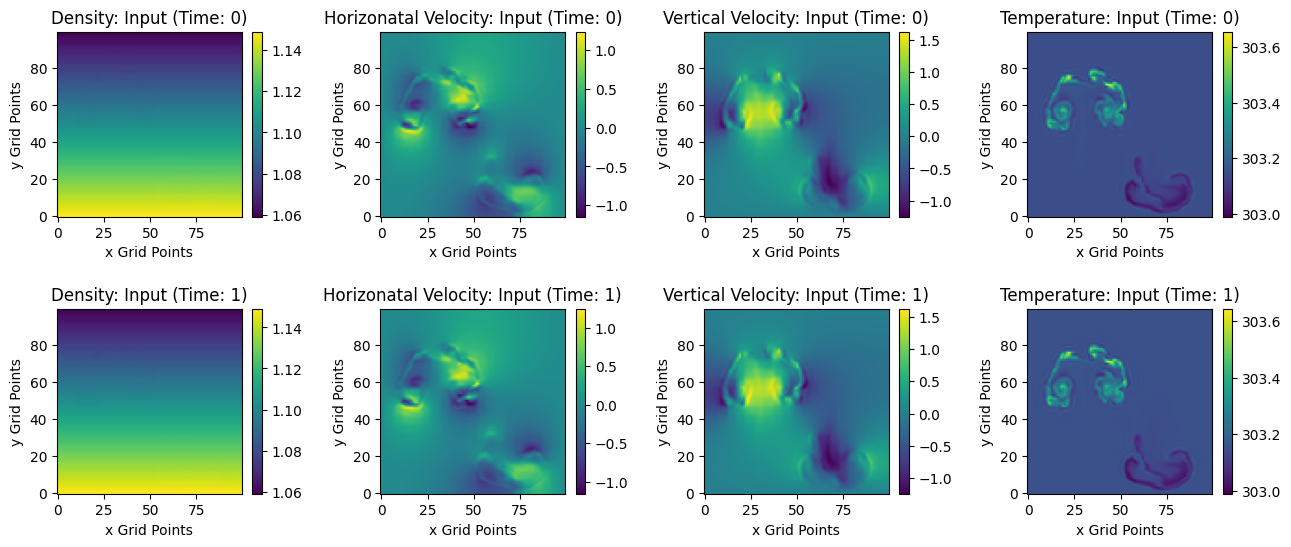

In [21]:
visual_pairs(x_train_data, y_train_data, 700)

# Data Augmentation

Transformation pipeline for computer vision tasks.

In [22]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std_range=(0.0, 0.1)):
        self.mean = mean
        self.std_range = std_range

    def __call__(self, tensor):
        if torch.rand(1) < 0.5:
            noise = torch.normal(self.mean, (self.std_range[1] - self.std_range[0]) * torch.rand(1).item(), size=tensor.size())
            return tensor + noise
        return tensor
    
class AddSaltAndPepperNoise(object):
    def __init__(self, prob=0.01):
        self.prob = prob

    def __call__(self, tensor):
        # Add salt-and-pepper noise
        if torch.rand(1) < 0.5:
            mask = torch.rand(tensor.shape)
            tensor[mask < self.prob / 2] = 0  # Salt
            tensor[mask > 1 - self.prob / 2] = 1  # Pepper
        return tensor

class RandomGaussianBlur(object):
    def __init__(self, kernel_size_range=(3, 7), sigma_range=(0.1, 2.0)):
        self.kernel_size_range = kernel_size_range
        self.sigma_range = sigma_range
        
    def __call__(self, image):
        if torch.rand(1) > 0.5:
            return image
        # Randomly choose kernel size and sigma within the specified range
        kernel_size = random.choice([k for k in range(self.kernel_size_range[0], self.kernel_size_range[1] + 1, 2)])
        sigma = random.uniform(self.sigma_range[0], self.sigma_range[1])

        # Generate a Gaussian kernel for blurring
        kernel = torch.arange(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=torch.float32)
        kernel = torch.exp(-0.5 * (kernel / sigma).pow(2))
        kernel = kernel / kernel.sum()  # Normalize

        # Apply the 1D kernel to blur the image in both horizontal and vertical directions
        kernel_2d = kernel[:, None] * kernel[None, :]  # Create a 2D Gaussian kernel
        kernel_2d = kernel_2d.expand(image.shape[0], 1, kernel_size, kernel_size)

        # Apply the 2D convolution to each channel
        image = image.unsqueeze(0)  # Add batch dimension for conv2d
        blurred_image = F.conv2d(image, kernel_2d, padding=kernel_size // 2, groups=image.shape[1])

        return blurred_image.squeeze(0)  # Remove batch dimension

aug_pipeline = v2.Compose([
    AddGaussianNoise(),
    AddSaltAndPepperNoise(),
    RandomGaussianBlur(),
    v2.RandomHorizontalFlip(p=0.5)
])

Create torch dataset and dataloader.

In [23]:
def indepent_channel_select(x_vec, channels=[3], seq_len=8):  
    tensor = torch.zeros((len(channels)*seq_len,) + x_vec.shape[1:])
    
    for ind in range(x_vec.shape[0] // 4):
        base_idx = ind * 4
        for idx, ch in enumerate(channels):
            if ch == 1:
                tensor[idx+ind*len(channels)] = x_vec[base_idx+1] / x_vec[base_idx]
            if ch == 2:
                tensor[idx+ind*len(channels)] = x_vec[base_idx+2] / x_vec[base_idx]
            if ch == 3:
                tensor[idx+ind*len(channels)] = x_vec[base_idx+3] / x_vec[base_idx]
    
    return tensor

In [24]:
def load_instances(data_instance, upsample_size=224, dtype=torch.float32, channels=4, seq_len=8, channel_select=[3]):
    np_instances = np.zeros((data_instance.shape[0], channels*10000))
    
    for idx, instance in enumerate(data_instance):
        np_instances[idx, :] = np.load(instance)
    
    torch_instances = torch.from_numpy(np_instances).to(dtype=dtype)
    
    if datasetConfig.upsample:
        inpt = nn.functional.interpolate(torch_instances.view(1, seq_len*channels, 100, 100), size=(upsample_size, upsample_size), mode='bicubic')
        return indepent_channel_select(inpt.view(channels*seq_len, upsample_size, upsample_size), seq_len=seq_len, channels=channel_select)
    
    return indepent_channel_select(inpt.view(channels*seq_len, 100, 100), seq_len=seq_len, channels=channel_select)    

In [25]:
def preprocess(input_tensor, target_tensor):
    # Compute the min and max values for each image in the batch
    in_mins = torch.amin(input_tensor, dim=(1, 2), keepdim=True)
    in_maxes = torch.amax(input_tensor, dim=(1, 2), keepdim=True)
    
    tar_mins = torch.amin(target_tensor, dim=(1, 2), keepdim=True)
    tar_maxes = torch.amax(target_tensor, dim=(1, 2), keepdim=True)
    
    # Apply min-max scaling to [0, 1]
    standard_input = (input_tensor - in_mins) / (in_maxes - in_mins + 1e-8)  # Adding a small epsilon to avoid division by zero
    standard_target = (target_tensor - tar_mins) / (tar_maxes - tar_mins + 1e-8)
    
    return standard_input, standard_target

In [26]:
class collidingBubbles(Dataset):
    def __init__(self, x, y, device, loading_func, preprocess_func, data_aug=None, channel_select=None):
        self.device = device
        self.x, self.y = x, y
        self.loading_func = loading_func
        self.preprocess_func = preprocess_func
        self.channel_selection = channel_select
        self.data_aug = data_aug

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x_instance, y_instance = self.x[idx], self.y[idx]
                
        inpt, target = self.loading_func(x_instance, seq_len=1, channel_select=[1, 2, 3]), self.loading_func(y_instance, seq_len=1, channel_select=[1, 2, 3])
        inpt, target = self.preprocess_func(inpt, target)
        
        if self.data_aug is not None:
            t = self.data_aug(torch.cat([inpt, target], axis=0))
            inpt_aug, target_aug = t[:3, :, :], t[3:, :, :]

            return inpt, target, inpt_aug, target_aug
        
        return inpt, target

In [27]:
train_dataset = collidingBubbles(x_train_data, y_train_data, datasetConfig.device, load_instances, preprocess)
valid_dataset = collidingBubbles(x_valid_data, y_valid_data,  datasetConfig.device, load_instances, preprocess)

In [28]:
train_dl = DataLoader(train_dataset, batch_size=datasetConfig.batch_size, shuffle=True, 
                      num_workers=datasetConfig.num_workers, drop_last=True, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size=datasetConfig.batch_size, shuffle=True, 
                      num_workers=32, drop_last=True, pin_memory=True)

In [29]:
def timeit(dl):
    start_time = time.time()
    for batch in tqdm(train_dl):
        pass
    print(f'Time with num_workers=64: {time.time() - start_time:.2f} seconds.')

In [30]:
if datasetConfig.loader_speed:
    timeit(dl)

## Tensor Helper/Visualization

Helper functions for tensors. Visualization options for tensors.

In [31]:
inputs, targets= next(iter(train_dl))

In [32]:
print(f'Batch input size: "{inputs.size()}", Batch target size: "{targets.size()}"')

Batch input size: "torch.Size([64, 3, 224, 224])", Batch target size: "torch.Size([64, 3, 224, 224])"


In [33]:
def visualize_instances(batch, ind, r):
    instance = batch[ind] 

    fig, axs = plt.subplots(r, 3, figsize=(15, 5*r))

    for i in range(r*3):
        ax = axs[i // 3, i % 3] if r > 1 else axs[i]
        ax.imshow(instance[i].detach().numpy(), cmap='gray')
        ax.set_title(f"Instance {i}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

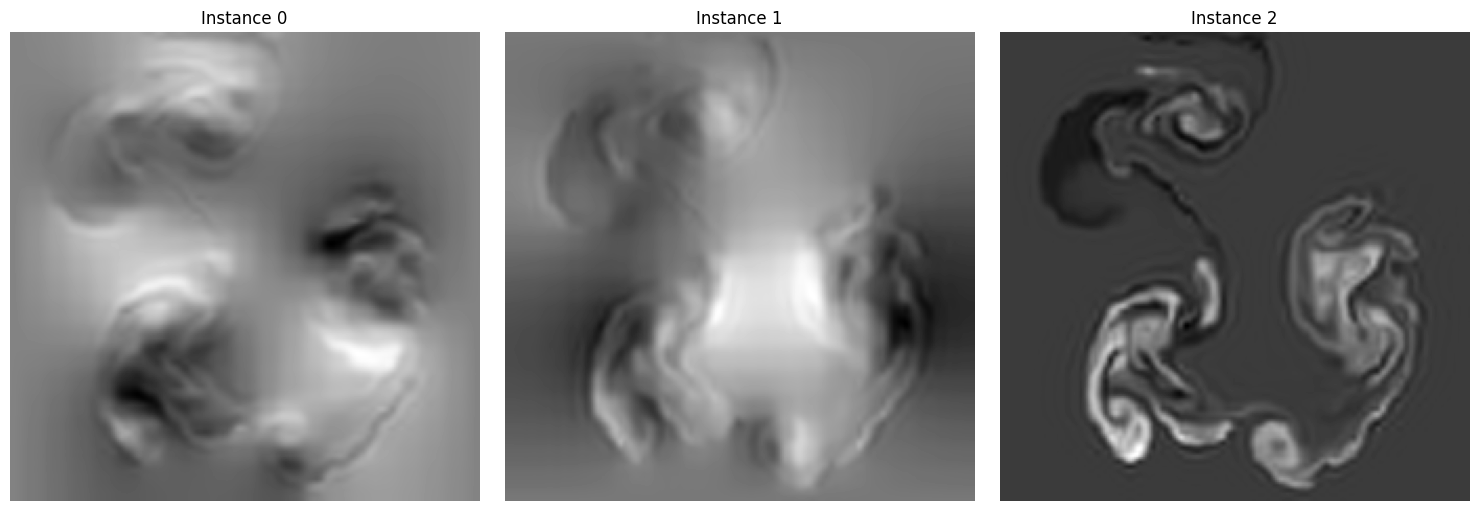

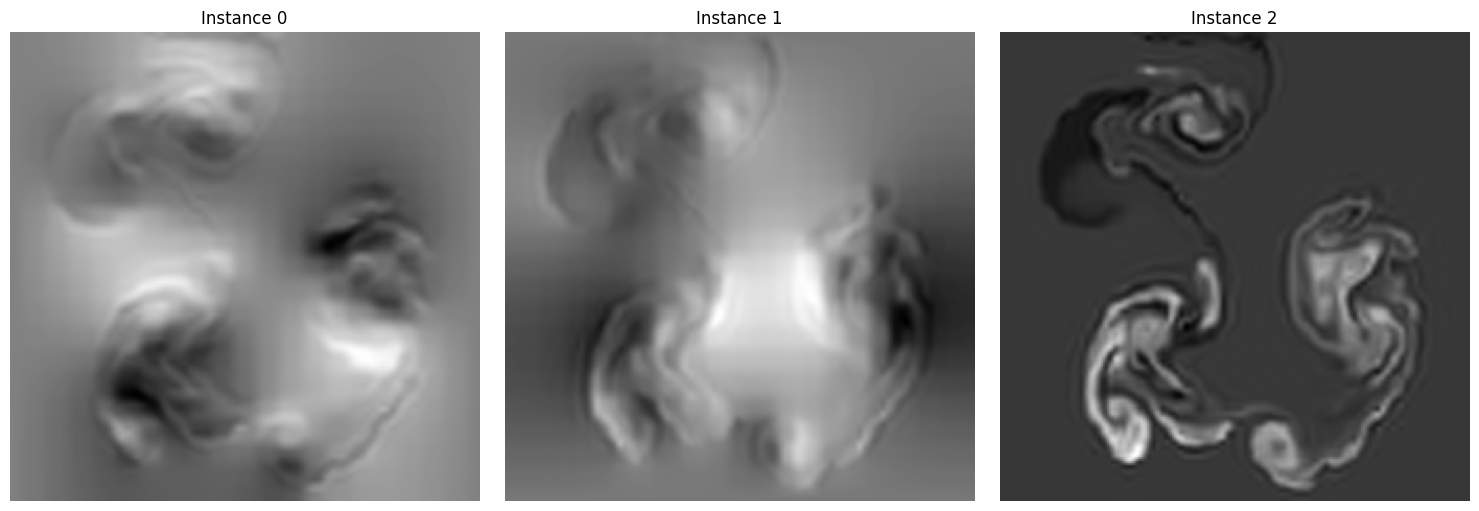

In [34]:
visualize_instances(inputs, 1, 1)
visualize_instances(targets, 1, 1)

In [35]:
# TODO: Show tensor number statistics

In [36]:
def visualize_batch(batch):
    cols = int(np.sqrt(datasetConfig.batch_size))
    rows = int(np.ceil(datasetConfig.batch_size / cols))
    
    fig, ax = plt.subplots(rows, cols, figsize=(20, 20))
    
    for col in range(cols):
        for row in range(rows):
            ind = col*cols + row
            ax[row][col].imshow(batch[ind][0], origin='lower')
        
            ax[row][col].set_xticks([])
            ax[row][col].set_yticks([])

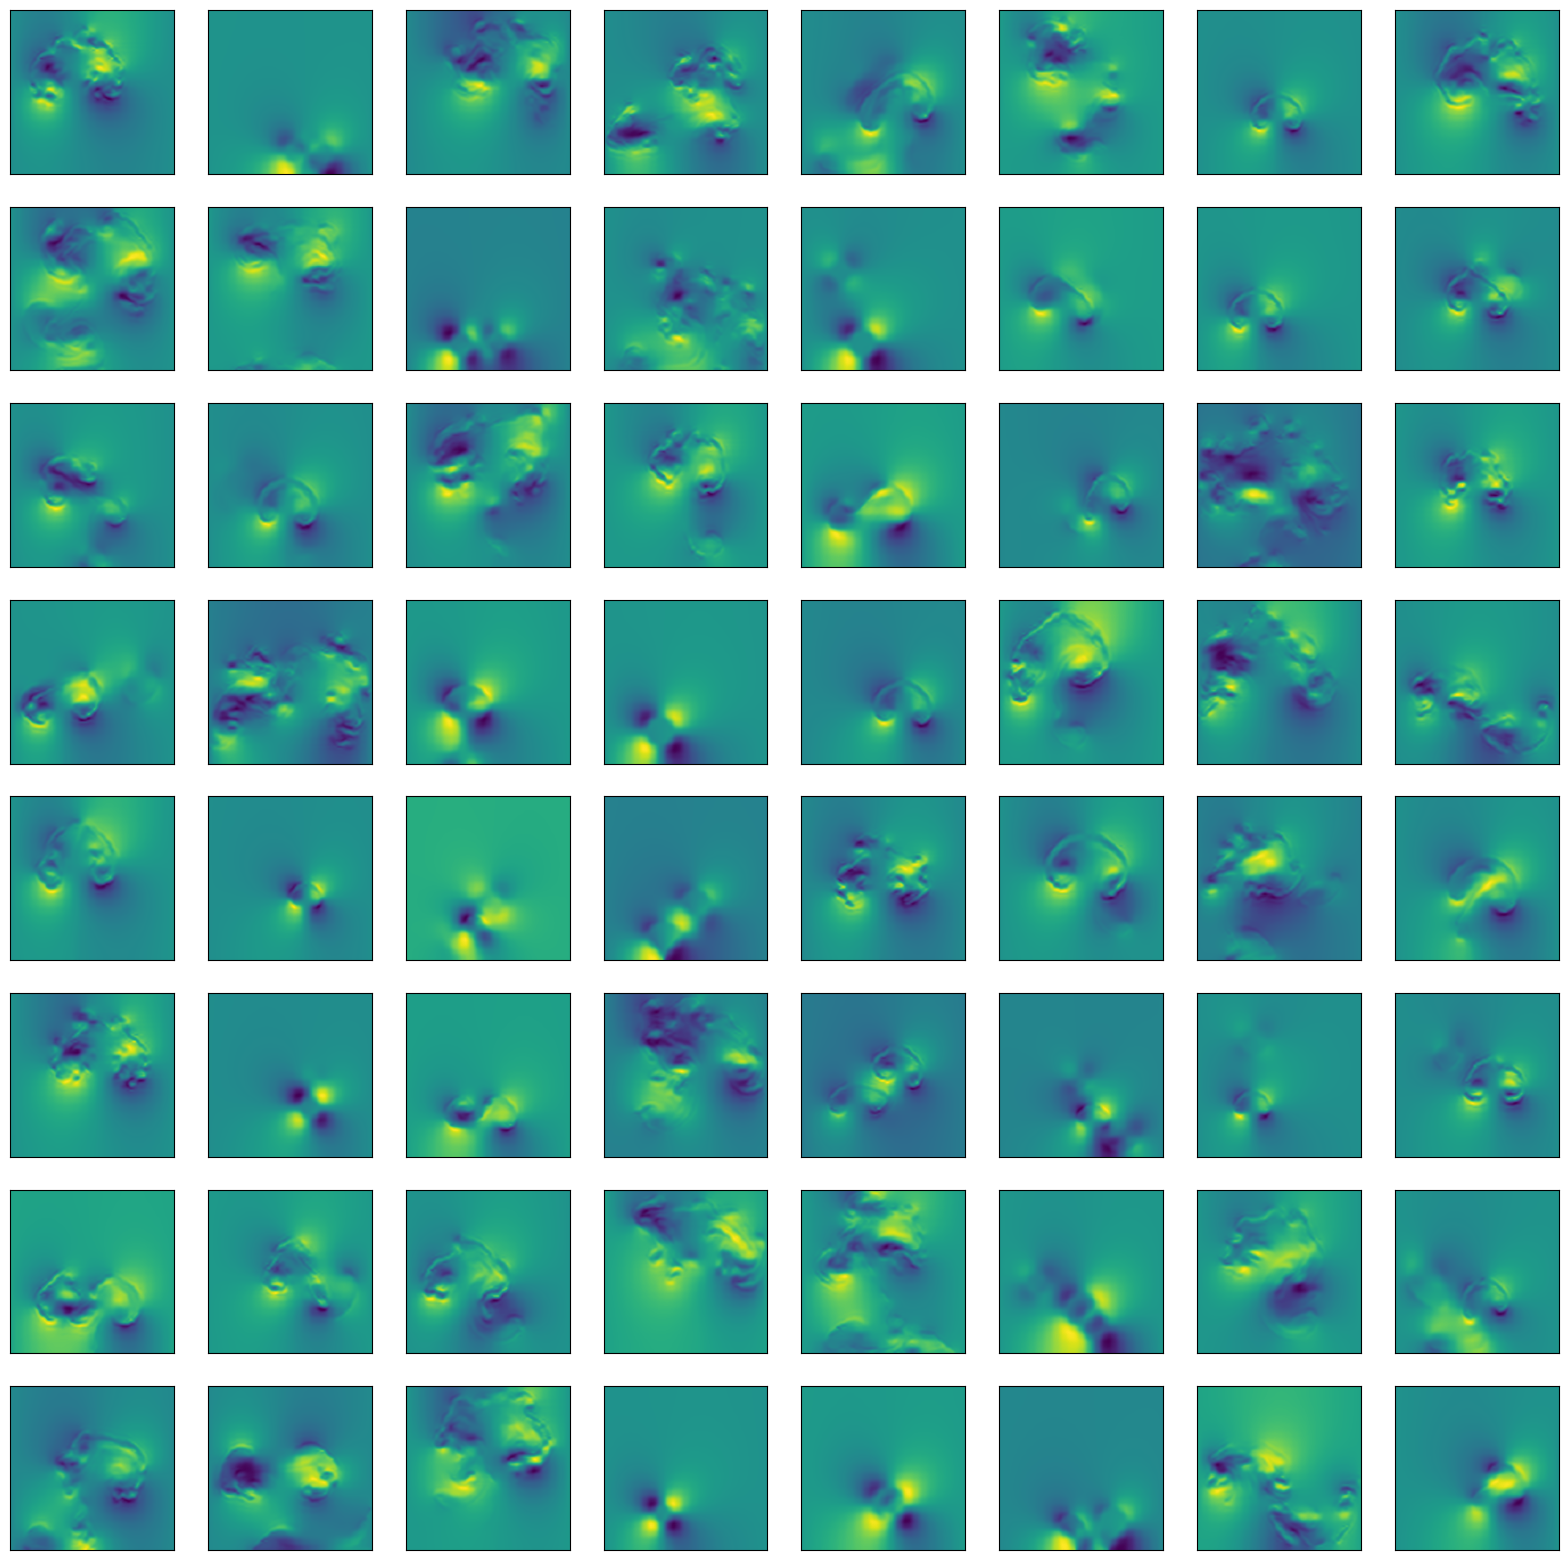

In [37]:
visualize_batch(inputs)

## Load Model

Load model from state dict.

In [38]:
def load_model_weights(model, state_dict_path):
    model.load_state_dict(torch.load(state_dict_path))

# Model Configuration

Model construction parameters: number of up-convs/down-convs, input size/channels, etc.

In [39]:
class ModelConfig:
    input_size = 100
    input_channels = 4
    output_size = 100
    output_channels = 4
    
    down_n = 4
    up_n = 4
    conv_blocks = 2
    
    latent_size = 1000
    epochs = 20
    patience = 10
    
    model = True
    model_pretrain_load = False
    model_additional_training = False
    
    weight_root = '/data/users/jupyter-dam724/Scripts/Modelling/weights/'

# Model Evaluation

Helper function to visualize how the models are doing.

In [40]:
def visual_train(rec, inpt, pred, tar, filename='ex'):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    
    fig.suptitle(f'Reconstruction Error: {np.linalg.norm(rec-inpt)}, Prediction Error: {np.linalg.norm(pred-tar)}')
        
    variables = 'Temperature'
        
    im_rec = ax[0][0].imshow(rec[0], origin='lower')
    im_inpt = ax[0][1].imshow(inpt[0], origin='lower')
    
    im_pred = ax[1][0].imshow(pred[0], origin='lower')
    im_tar = ax[1][1].imshow(tar[0], origin='lower')

    fig.colorbar(im_rec, ax=ax[0][0], orientation='vertical', fraction=0.046, pad=0.04)
    fig.colorbar(im_inpt, ax=ax[0][1], orientation='vertical', fraction=0.046, pad=0.04)
    
    fig.colorbar(im_pred, ax=ax[1][0], orientation='vertical', fraction=0.046, pad=0.04)
    fig.colorbar(im_tar, ax=ax[1][1], orientation='vertical', fraction=0.046, pad=0.04)

    ax[0][0].set_title(f'{variables}: Reconstruction')
    ax[0][1].set_title(f'{variables}: Input')
    ax[0][0].set_xlabel('x Grid Points')
    ax[0][0].set_ylabel('y Grid Points')
    ax[0][1].set_xlabel('x Grid Points')
    ax[0][1].set_ylabel('y Grid Points')
    
    ax[1][0].set_title(f'{variables}: Prediction')
    ax[1][1].set_title(f'{variables}: Target')
    ax[1][0].set_xlabel('x Grid Points')
    ax[1][0].set_ylabel('y Grid Points')
    ax[1][1].set_xlabel('x Grid Points')
    ax[1][1].set_ylabel('y Grid Points')
            
    plt.savefig(f'{ModelConfig.weight_root}{filename}.png')
    plt.show()

In [41]:
def visual_pretrain(rec, inpt, filename='ex'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    fig.suptitle(f'Reconstruction Error: {np.linalg.norm(rec-inpt)}')
        
    variables = 'Temperature'
        
    im_rec = ax[0].imshow(rec[0], origin='lower')
    im_inpt = ax[1].imshow(inpt[0], origin='lower')

    fig.colorbar(im_rec, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04)
    fig.colorbar(im_inpt, ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04)

    ax[0].set_title(f'{variables}: Reconstruction')
    ax[1].set_title(f'{variables}: Input')
    ax[0].set_xlabel('x Grid Points')
    ax[0].set_ylabel('y Grid Points')
    ax[1].set_xlabel('x Grid Points')
    ax[1].set_ylabel('y Grid Points')
            
    plt.savefig(f'{ModelConfig.weight_root}{filename}.png')
    plt.show()

In [42]:
def plot_training(train_log, valid_log, title='EX', filename='ex'):
    plt.plot(train_log, label="Train")
    plt.plot(valid_log, label="Valid")
    plt.title(f'{title}: Train/Valid Log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.savefig(f'{ModelConfig.weight_root}{filename}.png')
    plt.show()

# Model Diagnostics

Compute model diagnostics for fully connected network.

In [43]:
def get_params(model):
    params = 0

    # Look at the parameters NOT excluding the first param. Print and examime.
    for param in model.parameters():
        l = list(param.shape)
        params += int(torch.prod(torch.tensor(l)))
            
    return params

# Freeze/Unfreeze

Freezes/unfreezes the given model.

In [44]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad = False

In [45]:
def unfreeze(model):
    for param in model.parameters():
        param.requires_grad = True

# General Training Function

Function that makes training easy.

In [46]:
def check_point(val_loss, best_val_loss, model, patience_counter, save_path):
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
    else:
        patience_counter += 1
        
    return patience_counter, best_val_loss

In [47]:
def train(train, valid, model, epochs, patience, criterion, lr, save_path, util, train_log, valid_log, loading_bar=False):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, threshold=1e-3)
    
    best_val_loss = float('inf')
    patience_counter = 0
    scaler = torch.amp.GradScaler('cuda')

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        if loading_bar:
            loader = tqdm(train, desc=f'Training', leave=False, mininterval=2.0)
        else:
            loader = train
        
        for train_batch in loader:
            loss = util(train_batch, model, criterion)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            
            if loading_bar:
                loader.set_postfix(train_loss=loss.item())
                            
        train_loss /= len(train)
        train_log.append(train_loss)

        model.eval()
        val_loss = 0
        if loading_bar:
            loader = tqdm(valid, desc=f'Validation', leave=False, mininterval=2.0)
        else:
            loader = valid
        
        with torch.no_grad():
            for valid_batch in loader:
                loss = util(valid_batch, model, criterion)

                val_loss += loss.item()
                
                if loading_bar:
                    loader.set_postfix(val_loss=loss.item())
                                    
        val_loss /= len(valid)
        valid_log.append(val_loss)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        patience_counter, best_val_loss = check_point(val_loss, best_val_loss, model, patience_counter, save_path)

        if patience_counter >= patience:
            print('Early stopping triggered')
            break

In [48]:
def auto_regressive_train(train, valid, model, epochs, patience, criterion, lr, save_path, util, train_log, valid_log, ite, loading_bar=False):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, threshold=1e-3)
    
    best_val_loss = float('inf')
    patience_counter = 0
    scaler = torch.amp.GradScaler('cuda')

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        if loading_bar:
            loader = tqdm(train, desc=f'Training', leave=False, mininterval=2.0)
        else:
            loader = train
        
        for train_batch in loader:
            loss = util(train_batch, model, criterion, optimizer, scaler, ite[epoch], train=True)
            
            train_loss += loss
            
            if loading_bar:
                loader.set_postfix(train_loss=loss)
                            
        train_loss /= len(train)
        train_log.append(train_loss)

        model.eval()
        val_loss = 0
        if loading_bar:
            loader = tqdm(valid, desc=f'Validation', leave=False, mininterval=2.0)
        else:
            loader = valid
        
        with torch.no_grad():
            for valid_batch in loader:
                loss = util(valid_batch, model, criterion, optimizer, scaler, ite[epoch], train=False)

                val_loss += loss
                
                if loading_bar:
                    loader.set_postfix(val_loss=loss)
                                    
        val_loss /= len(valid)
        valid_log.append(val_loss)
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

        patience_counter, best_val_loss = check_point(val_loss, best_val_loss, model, patience_counter, save_path)

        if patience_counter >= patience:
            print('Early stopping triggered')
            break

# ViT Encooder

The **Beefy** ViT encoder.

In [49]:
class VITConfig:
    pretrain1 = False
    pretrain2 = False
    pretrain3 = True

In [50]:
vit = ViTModel.from_pretrained("google/vit-base-patch16-224").to(datasetConfig.device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
# Freeze most of the model
freeze(vit)
unfreeze(vit.pooler) # Unfreeze to finetune on koopman cordinate estimation

## Pretrain ViT-v0

Pretrain (learning the koopman coordinates) solely one-to-one.

In [52]:
class PretrainViT(nn.Module):
    def __init__(self, vit, latent_size=768):
        super(PretrainViT, self).__init__()
        
        self.vit = vit
        self.koopman = nn.Parameter(torch.empty(latent_size, latent_size))
        nn.init.orthogonal_(self.koopman)
        
    def forward(self, x, y, x_t, y_t):
        x_encoded = self.vit(x).pooler_output
        x_encoded_koopman = torch.matmul(x_encoded, self.koopman)
        
        y_encoded = self.vit(y).pooler_output
        
        x_t_encoded = self.vit(x_t).pooler_output
        y_t_encoded = self.vit(y_t).pooler_output
        
        return x_encoded, x_encoded_koopman, y_encoded, x_t_encoded, y_t_encoded

In [53]:
def pretrain_step(batch, model, criterion):
    x, y, x_t, y_t = batch
    y, y_t = y[:, 0:3, :, :], y_t[:, 0:3, :, :]

    x, y = x.to(datasetConfig.device), y.to(datasetConfig.device)
    x_t, y_t = x_t.to(datasetConfig.device), y_t.to(datasetConfig.device)

    loss = criterion(*model(x, y, x_t, y_t))
        
    return loss

In [54]:
class PretrainViTLoss(nn.Module):
    def __init__(self, a1, a2, a3):
        super(PretrainViTLoss, self).__init__()
        
        self.mae = nn.L1Loss()
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
        
    def forward(self, x_encoded, x_encoded_koopman, y_encoded, x_t_encoded, y_t_encoded):
        
        # Minimize distance btwn advanced koopman embedding and target embedding
        linearity = self.mae(x_encoded_koopman, y_encoded)
        
        # Maximize distance btwn input embedding and target embedding ? (scaled slightly lower)
        emb_d = -self.mae(x_encoded, y_encoded)
        
        # Minimize distance from augmented embeddings and ground truth ? (should the noisy vectors be close)
        rho = self.mae(x_t_encoded, x_encoded) + self.mae(y_t_encoded, y_encoded)
        
        return self.a1 * linearity + self.a2 * emb_d + self.a3 * rho

In [55]:
# previt = PretrainViT(vit).to(datasetConfig.device)

In [56]:
save_path = f'{ModelConfig.weight_root}vit_pretrain_0.pth'
pretrain_train_log = []
pretrain_valid_log = []

In [57]:
if VITConfig.pretrain1:
    loss = PretrainViTLoss(1.0, 1e-3, 1e-3)
    train(train_dl, valid_dl, previt, 10, 2, loss, 1e-5, save_path, pretrain_step, pretrain_train_log, pretrain_valid_log, loading_bar=True)
    plot_training(pretrain_train_log, pretrain_valid_log)

In [58]:
def inspect_embeddings(x, y, x_t, y_t, idx):
    x, y = x.to(datasetConfig.device), y[:, :3, :, :].to(datasetConfig.device)
    x_t, y_t = x_t.to(datasetConfig.device), y_t[:, :3, :, :].to(datasetConfig.device)

    out = previt(x, y, x_t, y_t)
    variables = ['encoded-x', 'x-advanced', 'encoded-y', 'encoded-x-clean', 'encoded-y-clean']
    
    for ind in range(len(variables)):
        print(f'{variables[ind]}: MAX[{out[idx][ind].max()}], MIN[{out[idx][ind].min()}], MEAN[{out[idx][ind].mean()}]')
        
    plt.matshow(previt.koopman.detach().cpu())

In [59]:
x, y = next(iter(train_dl))

In [60]:
# inspect_embeddings(x, y, x_t, y_t, 0)

## Pretrain ViT-v1

Pretrain (learning the koopman coordinates) solely one-to-four.

In [61]:
class AutoPretrainViT(nn.Module):
    def __init__(self, vit, koopman):
        super(AutoPretrainViT, self).__init__()
        
        self.vit = vit
        self.koopman = koopman
        
    def forward(self, x, y, x_t):
        x_encoded = self.vit(x).pooler_output
        
        x_encoded_koopman1 = torch.matmul(x_encoded, self.koopman)
        x_encoded_koopman2 = torch.matmul(x_encoded_koopman1, self.koopman)
        x_encoded_koopman3 = torch.matmul(x_encoded_koopman2, self.koopman)
        x_encoded_koopman4 = torch.matmul(x_encoded_koopman3, self.koopman)

        y_encoded1 = self.vit(y[:, 0:3, :, :]).pooler_output
        y_encoded2 = self.vit(y[:, 3:6, :, :]).pooler_output
        y_encoded3 = self.vit(y[:, 6:9, :, :]).pooler_output
        y_encoded4 = self.vit(y[:, 9:12, :, :]).pooler_output
        
        x_t_encoded = self.vit(x_t).pooler_output
        
        return x_encoded, x_encoded_koopman1, x_encoded_koopman2, x_encoded_koopman3, x_encoded_koopman4, y_encoded1, y_encoded2, y_encoded3, y_encoded4, x_t_encoded, self.koopman

In [62]:
class AutoPretrainViTLoss(nn.Module):
    def __init__(self, a1, a2, a3, a4):
        super(AutoPretrainViTLoss, self).__init__()
        
        self.mae = nn.L1Loss()
        self.mse = nn.MSELoss()
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
        self.a4 = a4
        self.identity = torch.eye(768).to(datasetConfig.device)
        
    def forward(self, x_encoded, x_encoded_koopman1, x_encoded_koopman2, x_encoded_koopman3, x_encoded_koopman4, y_encoded1, y_encoded2, y_encoded3, y_encoded4, x_t_encoded, koopman):
        
        # Minimize distance btwn advanced koopman embedding and target embedding
        linearity1 = self.mae(x_encoded_koopman1, y_encoded1)
        linearity2 = self.mae(x_encoded_koopman2, y_encoded2)
        linearity3 = self.mae(x_encoded_koopman3, y_encoded3)
        linearity4 = self.mae(x_encoded_koopman4, y_encoded4)
        linearity = linearity1 + linearity2 + linearity3 + linearity4
        
        # Maximize distance btwn input embedding and target embedding ? (scaled slightly lower)
        emb_d_1 = -self.mae(x_encoded, y_encoded1)
        emb_d_2 = -self.mae(x_encoded_koopman1, y_encoded2)
        emb_d_3 = -self.mae(x_encoded_koopman2, y_encoded3)
        emb_d_4 = -self.mae(x_encoded_koopman3, y_encoded4)
        emb_d = emb_d_1 + emb_d_2 + emb_d_3 + emb_d_4
        
        # Encourage koopman operator to go towards identity ? (very small weight)
        loss_identity_reg = self.mse(koopman, self.identity)
        
        # Rhobustness to noise
        rho = self.mae(x_t_encoded, x_encoded)
        
        return self.a1 * linearity + self.a2 * emb_d + self.a3 * loss_identity_reg + self.a4 * rho

In [63]:
def multi_pretrain_step(batch, model, criterion):
    x, y, x_t, _ = batch
    x, y, x_t = x.to(datasetConfig.device), y.to(datasetConfig.device), x_t.to(datasetConfig.device)

    return criterion(*model(x, y, x_t))

In [64]:
# autoprevit = AutoPretrainViT(previt.vit, previt.koopman)

In [65]:
save_path = f'{ModelConfig.weight_root}vit_pretrain_auto_0.pth'
pretrain2_train_log = []
pretrain2_valid_log = []

In [66]:
if VITConfig.pretrain2:
    loss = AutoPretrainViTLoss(1.0, 1e-2, 1e-3, 1e-1)
    train(train_dl, valid_dl, autoprevit, 10, 2, loss, 1e-5, save_path, multi_pretrain_step, pretrain2_train_log, pretrain2_valid_log, loading_bar=False)
    plot_training(pretrain_train_log, pretrain_valid_log)

In [67]:
def inspect_embeddings(x, y, x_t, idx):
    x, y = x.to(datasetConfig.device), y.to(datasetConfig.device)
    x_t = x_t.to(datasetConfig.device)

    out = autoprevit(x, y, x_t)
    variables = ['encoded-x', 'x-advanced', 'encoded-y', 'encoded-x-clean', 'encoded-y-clean']
    
    for ind in range(len(variables)):
        print(f'{variables[ind]}: MAX[{out[idx][ind].max()}], MIN[{out[idx][ind].min()}], MEAN[{out[idx][ind].mean()}]')
        
    plt.matshow(autoprevit.koopman.detach().cpu())

In [68]:
x, y = next(iter(train_dl))

In [69]:
# inspect_embeddings(x, y, x_t, 0)

## Pretrain ViT-v2

### TODO

Training just the decoder.

In [70]:
class KoopmanViT(nn.Module):
    def __init__(self, vit, latent_size=768):
        super(KoopmanViT, self).__init__()
        
        self.encoder = vit
        self.koopman = nn.Linear(56 * 56, 56 * 56)
        self.tanh = nn.Tanh()
        
        # Fully connected layer to reshape latent size to 3136 (56x56)
        layers = []
        
        layers.append(nn.Linear(latent_size, 1400))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(1400, 2000))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(2000, 56 * 56))
        layers.append(nn.ReLU())
        
        self.upscale = nn.Sequential(*layers)
        
        layers = []
        
        layers.append(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False))
        layers.append(nn.Conv2d(1, 32, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(32))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(32, 32, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(32))
        layers.append(nn.ReLU())
        layers.append(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False))
        layers.append(nn.Conv2d(32, 16, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(16))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(16, 16, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(16))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(16, 3, kernel_size=3, padding=1))
        layers.append(nn.Sigmoid())
        
        self.decoder2 = nn.Sequential(*layers)
    
    def forward(self, x, y):
        x_encoded = self.upscale(self.encoder(x).pooler_output)
        
        x_recon = self.decoder2(x_encoded.view(64, 1, 56, 56))
                
        x_encoded_koopman = self.koopman(x_encoded)
        
        x_predicted = self.decoder2(x_encoded_koopman.view(64, 1, 56, 56))
        
        y_encoded = self.upscale(self.encoder(y).pooler_output)
        
        x_predicted_encoded = self.upscale(self.encoder(x_predicted).pooler_output)
        
        return x, y, x_predicted, y_encoded, x_predicted_encoded, x_encoded_koopman, x_recon

In [71]:
class KoopmanViTLoss(nn.Module):
    def __init__(self, a1, a2, a3, a4):
        super(KoopmanViTLoss, self).__init__()
        
        self.mse = lambda x, y: torch.mean(torch.mean(torch.linalg.norm(x - y, dim=(2, 3)), dim=1))
        self.mae = lambda x, y: torch.mean(torch.linalg.norm(x - y, dim=1, ord=1))
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
        self.a4 = a4
        
    def forward(self, x, y, x_predicted, y_encoded, x_predicted_encoded, x_encoded_koopman, x_recon):
        
        # Reconstruction
        recon = self.mse(x, x_recon)
        
        # Prediction
        pred = self.mse(x_predicted, y)
        
        # Linearity
        lin = self.mae(x_encoded_koopman, y_encoded) 
        
        # additional noise reduction
        noise1 = self.mae(x_predicted_encoded, y_encoded)
        #noise2 = self.mse(x-y, x_recon-x_predicted) 
                        
        return self.a1 * recon + self.a2 * pred + self.a3 * lin + self.a4 * noise1

In [72]:
def pretrain_step(batch, model, criterion):
    x, y = batch

    x, y = x.to(datasetConfig.device), y.to(datasetConfig.device)

    loss = criterion(*model(x, y))
        
    return loss

In [73]:
save_path = f'{ModelConfig.weight_root}vit_pretrain_enc_dec_2.pth'
pretrain3_train_log = []
pretrain3_valid_log = []

In [74]:
koopmanvit = KoopmanViT(vit).to(datasetConfig.device)

In [84]:
if VITConfig.pretrain3:
    loss = KoopmanViTLoss(1.0, 1.0, 1e-1, 1e-1)
    train(train_dl, valid_dl, koopmanvit, 15, 2, loss, 1e-5, save_path, pretrain_step, pretrain3_train_log, pretrain3_valid_log, loading_bar=False)
    plot_training(pretrain3_train_log, pretrain3_valid_log)

Epoch 1/15, Train Loss: 43.66137830742582, Validation Loss: 44.42831168873451
Epoch 2/15, Train Loss: 40.78105423106897, Validation Loss: 42.621940249955436
Epoch 3/15, Train Loss: 38.745477519805775, Validation Loss: 41.73058425981772


KeyboardInterrupt: 

In [76]:
x, y = next(iter(train_dl))

In [85]:
koopmanvit.eval()
with torch.no_grad():
    out = koopmanvit(x.to(datasetConfig.device), y.to(datasetConfig.device))

In [86]:
for i in out:
    print(i.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3136])
torch.Size([64, 3136])
torch.Size([64, 3136])
torch.Size([64, 3, 224, 224])


tensor(11.9836463928, device='cuda:3')
tensor(35.3029937744, device='cuda:3')


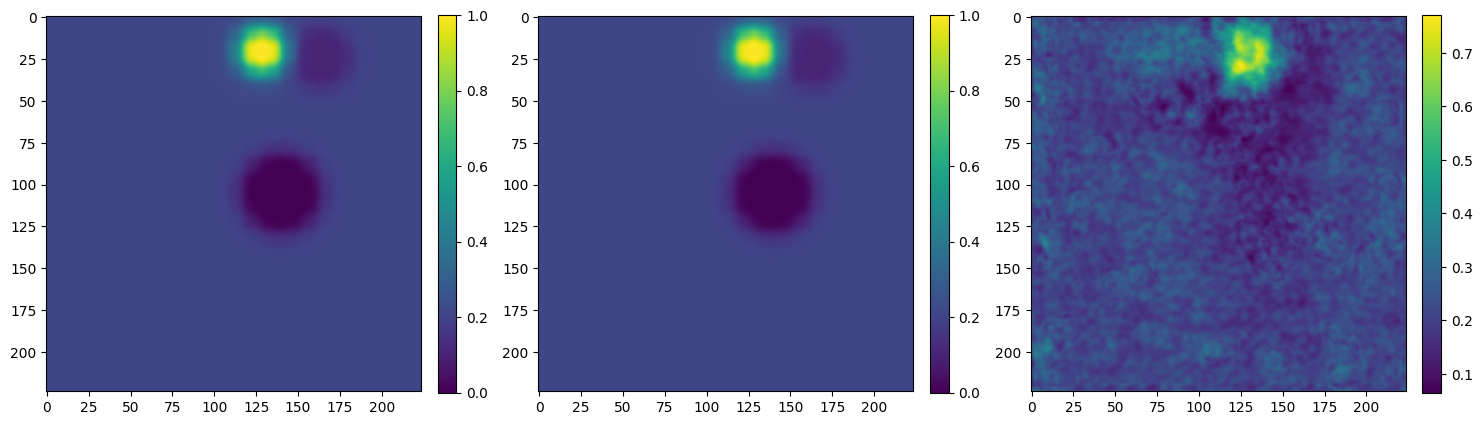

In [91]:
ind = 0
channel = 2

fig, ax = plt.subplots(1, 3, figsize=(18, 8))

a1 = ax[0].imshow(out[0][ind][channel].cpu())
a2 = ax[1].imshow(out[1][ind][channel].cpu())
a3 = ax[2].imshow(out[2][ind][channel].cpu())

fig.colorbar(a1, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(a2, ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(a3, ax=ax[2], orientation='vertical', fraction=0.046, pad=0.04)

print(torch.linalg.norm(out[1][ind][channel] - out[2][ind][channel]))
#print(torch.linalg.norm(out[2][ind][channel] - out[2][ind][channel+1]))
print(torch.linalg.norm(out[2][ind][channel] - out[2][ind+1][channel]))

# Advance Time

Step through time and see output.

In [ ]:
pred, ground = [], []

*Get ground instances.*

In [ ]:
for i in range(0, valid_set[1]):
    inpt, target, mean, std = preprocess(*load_instances(valid_data[i]))
    ground.append(inpt)

*Get predicted instances.*

In [ ]:
inputs, targets, _, _ = preprocess(*load_instances(valid_data[0]))
inputs, targets = inputs.repeat(28, 1, 1, 1), targets.repeat(28, 1, 1, 1)

pred.append(inputs[0])

In [ ]:
model.eval()
with torch.no_grad():
    decoder_rec, decoder_pred, _, _, _ = model(inputs.to(datasetConfig.device), targets.to(datasetConfig.device))
    pred.append(decoder_pred[0].cpu())

    for _ in range(valid_set[1]-2):
        _, decoder_pred, _, _, _ = model(decoder_pred, decoder_pred)
        pred.append(decoder_pred[0].cpu())

## Seqeuence Evaluation

See how the model is doing.

In [ ]:
def seq_animation(sequence, title):
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    
    ax[0][0].axis('off')
    ax[1][0].axis('off')
    ax[0][1].axis('off')
    ax[1][1].axis('off')
    
    x_0_ind = sequence[0]
        
    a = ax[0][0].imshow(x_0_ind[0], origin='lower')
    b = ax[1][0].imshow(x_0_ind[1], origin='lower')
    c = ax[0][1].imshow(x_0_ind[2], origin='lower')
    d = ax[1][1].imshow(x_0_ind[3], origin='lower')
    
    ax[0][0].set_title('Density')
    ax[1][0].set_title('Horizontal Velocity')
    ax[0][1].set_title('Vertical Velocity')
    ax[1][1].set_title('Temperature')
    
    fig.colorbar(a, ax=ax[0][0], orientation='vertical', fraction=0.046, pad=0.04)
    fig.colorbar(b, ax=ax[1][0], orientation='vertical', fraction=0.046, pad=0.04)
    fig.colorbar(c, ax=ax[0][1], orientation='vertical', fraction=0.046, pad=0.04)
    fig.colorbar(d, ax=ax[1][1], orientation='vertical', fraction=0.046, pad=0.04)
    
    plt.savefig(f'{title}.png')

    def update_frame(i):
        ax[0][0].clear()
        ax[1][0].clear()
        ax[0][1].clear()
        ax[1][1].clear()
                
        x_ind = sequence[i]
        
        a = ax[0][0].imshow(x_ind[0], origin='lower')
        b = ax[1][0].imshow(x_ind[1], origin='lower')
        c = ax[0][1].imshow(x_ind[2], origin='lower')
        d = ax[1][1].imshow(x_ind[3], origin='lower')
        
        if i == 54 or i == 108 or i == 162 or i == 214:
            plt.savefig(f'{title}_{i}.png')
    
        return [a, b, c, d]

    ani = animation.FuncAnimation(fig, update_frame, frames=215, interval=1, blit=True)
    
    print(f'Generating animation.')

    output_path = f'{title}.gif'
    ani.save(output_path, writer='Pillow', fps=1)

In [ ]:
seq_animation(pred, 'vae_01_pred')

In [ ]:
seq_animation(ground, 'vae_01_ground')